<div style="border:solid green 3px; padding: 20px">
<b>Результат участия в Kaggle Competition:</b>  
    
    Accuracy: 0.77272
    Место в турнирной таблице: 10157 из 15637 (65%)

# Titanic: Classification

#### Оглавление
[1. Получение данных](#1.0)  
[2. Исследовательский анализ данных](2.0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.1. Survived](#2.1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.2. Количесвтенные переменные](#2.2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.3. Качесвтенные переменные](#2.3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.4. Карреляции](#2.4)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[2.5. Зависимости для Survived](#2.5)  
[3. Предобработка данных](#3.0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.1. Пропущенные значения](#3.1)   
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.2. Работа с признаками](#3.2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[3.3. Scaling и Encoding](#3.3)  
[4. Обучение моделей](#4.0)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.1. Выбираем лучшую модель](#4.1)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.2. Pipeline](#4.2)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.3. Voting Classifier](#4.3)  
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;[4.4. CatBoostClassifier](#4.4)

**Задача:** Cоздать бинарный классификатор, который на основе feature vector $\textbf{x}^{(i)}$ предсказывает, выжевет ли $i$-ый пассажир Титаника после крушения. Данная задача — задача классификации; для обучения модели используется обучение с учителем.

**Данные**: Файлы `titanic_train.csv` и `titanic_test.csv` соедржат обучающиую и тестовую выборки соовтетственно; формат предсказания — датафрейм из двух столбцов: `PassengerID` и `Survived` в формате `0`: не выжил; `1`: выжил

**Метрика**: Accuracy — доля правильно предсказанных исходов

**Описание данных:**

| Название столбца | Описание данных |
|------------------|-----------------|
|`id` | уникальный номер пассажира |
|`survived` | выжил ли пассажир — `0`: не выжил, `1`: выжил |
|`pclass` | класс билета — `1`, `2` или `3` |
|`name` | имя |
|`sex` | пол — `male`, `female` |
|`age` | возраст |
|`sibsp` | число братьев / сестер / супругов на борту |
|`parch` | число родителей / детей на борту |
|`ticket` | номер билета |
|`fare` | цена билета |
|`cabin` | номер каюты |
|`embarked` | порт посадки — `C`: Шербур, `Q`: Квинстаун, `S`: Саутгемптон |

## 1. Получение данных
<a class="anchor" id="1.0"></a>

In [189]:
# Импортируем библиотеки
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)
import re
from scipy import stats

import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import seaborn as sns
plt.style.use('sonia')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from sklearn.preprocessing import OrdinalEncoder, RobustScaler
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import Pipeline

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from tpot import TPOTClassifier

from catboost import Pool, CatBoostClassifier, cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Загрузим обучающую и тестовую выборки и сохраним их в переменные `train` и `test` соответственно:

In [190]:
# Загружаем данные
train = pd.read_csv('titanic_train.csv')
test = pd.read_csv('titanic_test.csv')
submission = pd.read_csv('submission_example.csv')

Получим основную информацию по датафреймам:

In [191]:
# Создадим функцию для получения основной информации
def get_inf(df):
    '''
    Принимает датафрейм и возвращает
    - первые 5 строк
    - основную информацию о датасете
    - описательные статистики
    - число пропусков по столбцам
    '''
    print(f'Размерность: {df.shape}\n')
    display(df.head())
    display(df.describe())
    display(df.info())
    print('\nЧисло пропусков:')
    miss = (pd.DataFrame(df.isna().sum(), columns=['count'])
     .join(pd.DataFrame(round(df.isna().sum() * 100 / len(df), 2), columns=['%'])))
    display(miss[miss['count'] != 0])

In [192]:
print('\nОбучающие данные\n')
get_inf(train)


Обучающие данные

Размерность: (891, 12)



,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


Число пропусков:


,count,%
Age,177,19.87
Cabin,687,77.10
Embarked,2,0.22


In [193]:
print('\nТестовые данные\n')
get_inf(test)


Тестовые данные

Размерность: (418, 11)



,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


None


Число пропусков:


,count,%
Age,86,20.57
Fare,1,0.24
Cabin,327,78.23


Датафрейм `train` разделим на матрицу признаков `X` и вектор `y` со значениями переменной `Survived`:

In [194]:
y = train['Survived']
X = train.drop('Survived', axis=1)

Заполним пропуски в столбце `Embarked` на `'S'` ([информация](https://www.encyclopedia-titanica.org/titanic-survivor/amelia-icard.html)) и пропуск в столбце `Fare` на `7.5` ([информация](https://www.encyclopedia-titanica.org/titanic-victim/thomas-storey.html)):

In [195]:
X['Embarked'] = X['Embarked'].fillna('S')
test['Fare'] = test['Fare'].fillna(7.5)

## 2. Исследовательский анализ данных
<a class="anchor" id="2.0"></a>

### 2.1. Survived
<a class="anchor" id="2.1"></a>

Целевая переменная `Survived` распределена следующим образом:

Выживших:   38.38%
Невыживших: 61.62%



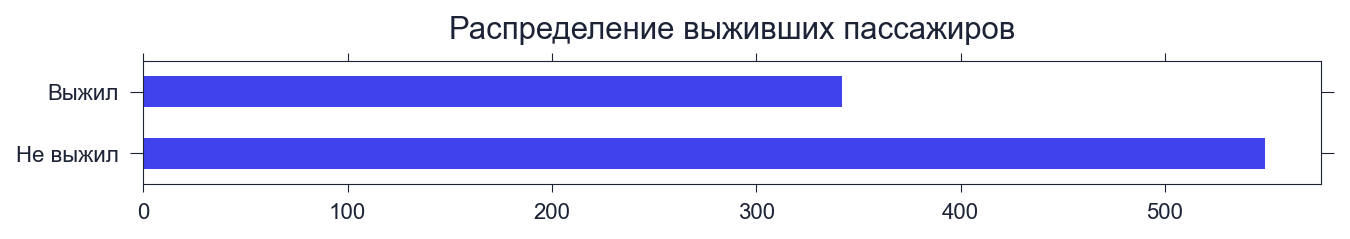

In [196]:
print(f'Выживших:   {y.value_counts()[1] /len(y):.2%}\n\
Невыживших: {y.value_counts()[0] / len(y):.2%}\n')

# Построим столбчатую диаграмму
ax = subplots(figsize=(9.5, 1))[1]
ax = y.value_counts().plot.barh()
ax.set_yticks((1, 0), ['Выжил', 'Не выжил'])
ax.set_ylabel(None)
ax.set_title('Распределение выживших пассажиров');

### 2.2. Количественные переменные
<a class="anchor" id="2.2"></a>

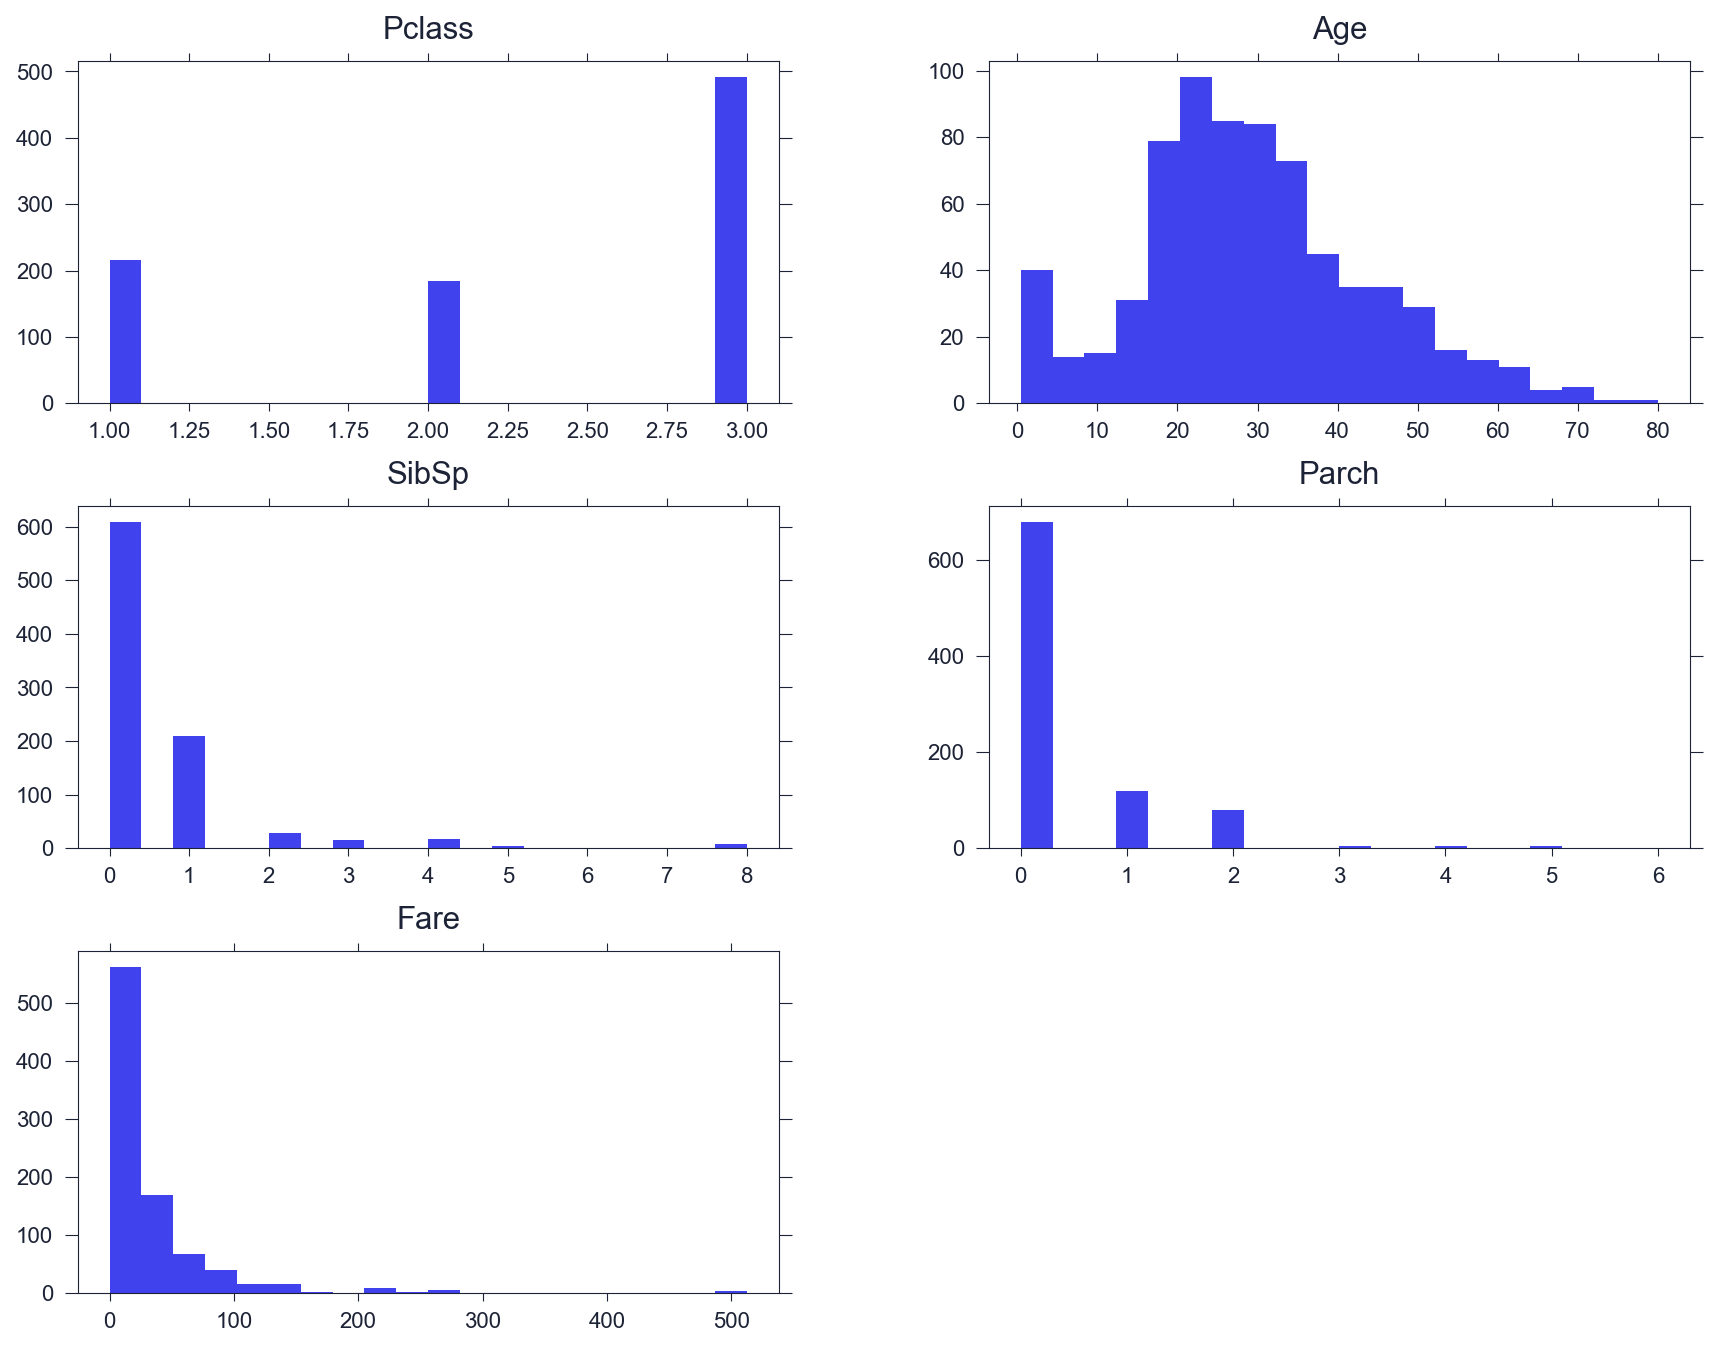

In [197]:
# Числовые переменные
numeric = [f for f in X.columns if train.dtypes[f] != 'object' and f != 'PassengerId']

# Их распределения
X[numeric].hist(bins=20, figsize=(13, 10), grid=False);

На этапе предобработки распределение признака `Age` необходимо будет преобразовать с помощью логарифма, а также добавить дополнительный признак из-за выброса в районе нуля: является ли пассажир моложе 5 лет.

Посмотрим на корреляцию для выбора наиболее важных для предсказания признаков; будем использовать корреляцию Спирмена, чтобы установить наличие, в том числе, и нелинейной связи:

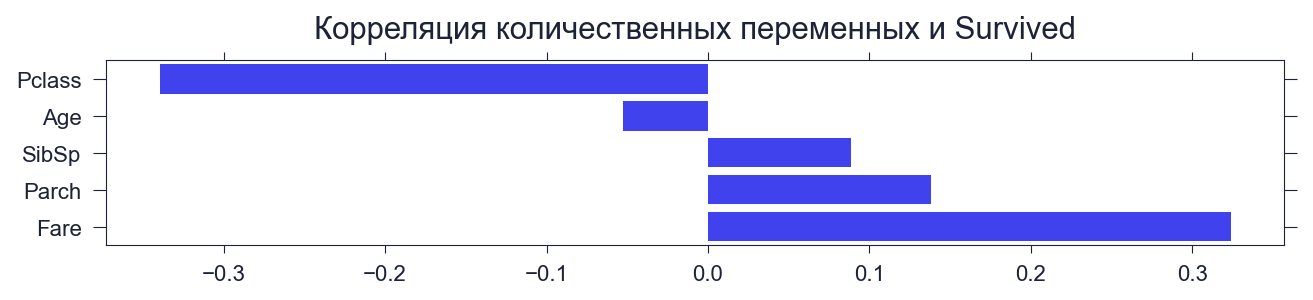

In [198]:
# Функция дл определения коэффициента корреляции
def spearman(df_1, features):
    '''
    Функция принимает датафрейм-матрицу признаков X и список признаков 
    и возвращает датафрейм со значениями коэффициента корреляции Спирмена для
    всех указанных признаков
    '''
    df = df_1.join(y)
    spr = pd.DataFrame()
    spr['feature'] = features
    spr['spearman'] = [df[f].corr(df['Survived'], 'spearman') for f in features]
    spr = spr.sort_values('spearman')
    return spr

# Визуализируем результат
result = spearman(X, numeric)
ax = subplots(figsize=(9.5, 1.5))[1]
sns.barplot(data=result, y='feature', x='spearman', saturation=1)
ax.set_xlabel(None)
ax.set_ylabel(None)
ax.set_title('Корреляция количественных переменных и Survived');

Наибольшие коэффициенты корреляции с целевой переменной — у признаков `Pclass` и `Fare`.

### 2.3. Качественные переменные
<a class="anchor" id="2.3"></a>

Обработаем значения качественных переменных в `X` и `test`:
1. Переменную `Name` заменим на префикс пассажира;
2. Для переменной `Cabin` заполним пропуски на `'N'` и добавим столбец `CabinLetter` с первой буквой столбца `Cabin`;
3. Для переменной `Ticket` добавим переемнные `TicketCount` с числом повторяющихся билетов и `TicketPrefix` с префиксом билета, а в самой переменной оставим только номер билета.

In [199]:
# Заменяем Name на префикс имени
def get_prefix(name):
    '''
    Функция принимает имя пассажира и возвращает префикс (если он имеется),
    или пустое значение (если префикса нет)
    '''
    prefix = re.search(' ([A-Za-z]+)\.', name)
    if prefix:
        return prefix.group(1)
    return ''

X['Name'] = X['Name'].apply(get_prefix)
test['Name'] = test['Name'].apply(get_prefix)

In [200]:
# Заполняем пропуски в Cabin и оставляем первую букву
def get_cabin(df):
    '''
    Функция принимает датасет, заполняет пропуски в столбце `Cabin` на 'N'
    и добавляет столбец `CabinLetter` с первой буквой столбца
    '''
    df['Cabin'] = df['Cabin'].fillna('N')
    df['CabinLetter'] = df['Cabin'].str[0]

get_cabin(X)
get_cabin(test)

# В датасете X заменим 'T' на 'N'
X['CabinLetter'] = X['CabinLetter'].replace('T', 'N')

In [201]:
def get_ticket(df):
    '''
    Функция принимает датасет и:
    1. Добавляет столбец `TicketCount`
    2. Добавляет столбец `TicketPrefix`
    3. В столбце `Ticket` оставляет только номер билета
    '''
    ticket_count = df.groupby('Ticket').size()
    df['TicketCount'] = df['Ticket'].map(ticket_count)
    df['TicketPrefix'] = (df['Ticket']
                         .apply(lambda x: ''.join(filter(str.isalpha, x))))
    df['TicketPrefix'] = df['TicketPrefix'].replace('', 'NoPrefix')
    df['Ticket'] = (df['Ticket']
                    .apply(lambda x: ''.join(filter(str.isdigit, x))))
    df['Ticket'] = df['Ticket'].replace('', '370160')
    df['Ticket'] = df['Ticket'].astype(int)

get_ticket(X)
get_ticket(test)

Чтобы оценить влияние качественных переменных на `Survived`, построим столбчатые диаграммы:

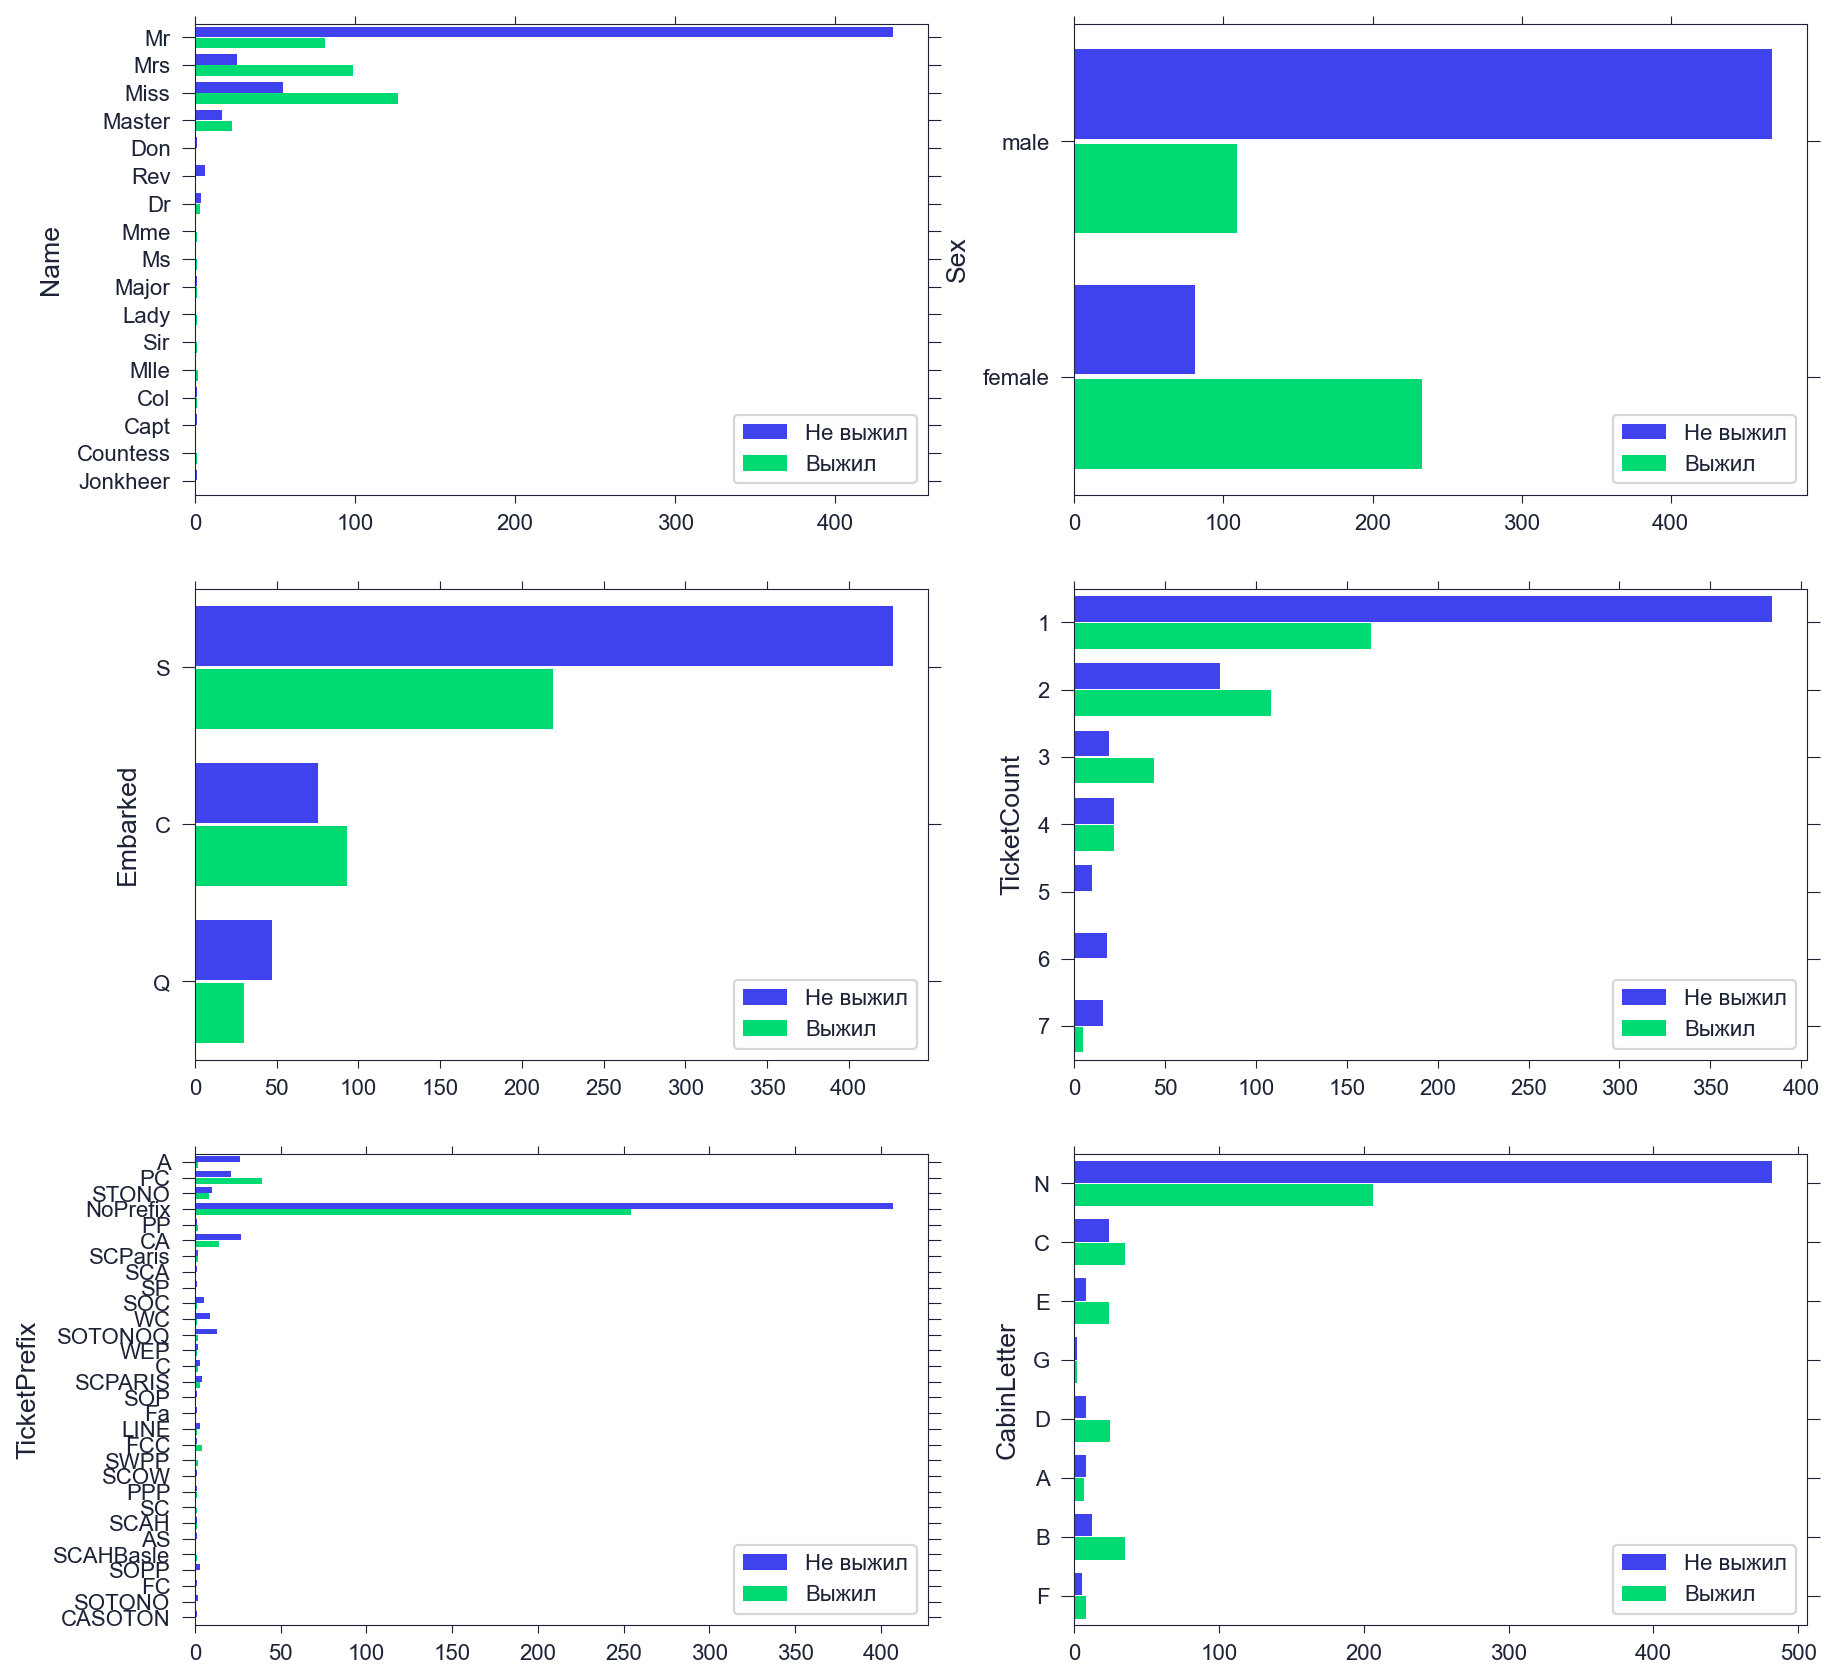

In [202]:
# Признаки для диаграмм
qualit = ['Name', 'Sex', 'Embarked',
          'TicketCount', 'TicketPrefix', 'CabinLetter']
X_cop = X.join(y)
n = -1

# Посмтроим диаграммы
fig, axes = subplots(figsize=(13, 13), ncols=2, nrows=3)
for i in range(3):
    for j in range(2):
        n += 1
        sns.countplot(y=qualit[n], hue='Survived', data=X_cop,
                      gap=0.05, saturation=1, ax=axes[i, j])
        axes[i, j].set_xlabel(None)
        axes[i, j].legend(loc='lower right', labels=['Не выжил', 'Выжил'])

Определим те категориальные переменные, которые в наибольшей мере обуславливают изменчивоть `Survived` — для этого воспользуемся дисперсионным анализом:

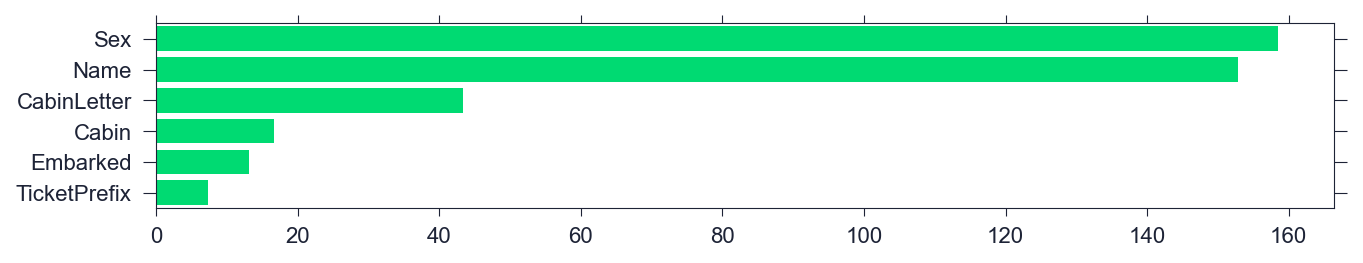

In [203]:
# Выберем все качественные переменные
qualit = [f for f in X.columns if X.dtypes[f] == 'object']

# Функция для определения p-value
def anova(df_1):
    '''
    Функция принимает датафрейм-матрицу признаков X и возвращает
    датафрейм со значениями p-value для всех категориальных признаков
    '''
    df = df_1.join(y)
    anv = pd.DataFrame()
    anv['feature'] = qualit
    p_vals = []
    for c in qualit:
        samples = []
        for cls in df[c].unique():
            s = df[df[c] == cls]['Survived'].values
            samples.append(s)
        p_val = stats.f_oneway(*samples)[1]
        p_vals.append(p_val)
    anv['p_val'] = p_vals
    anv['disparity'] = np.log(1./anv['p_val'].values)
    return anv.sort_values('p_val')

# Визуализируем результат
result = anova(X)
ax = subplots(figsize=(9.5, 1.5))[1]
sns.barplot(data=result, y='feature', x='disparity',
            saturation=1, color='#00DA72')
ax.set_xlabel(None)
ax.set_ylabel(None);

Таким образом, наиболее важными качесвтенными переменными являются `Sex` и `Name` (и в меньшей мере — `CabinLetter`).

Кроме того, нет смысла использовать все разновидности переменной `Name`, т. к. наблюдения с многими из префиксов встречаются достаточно редко. Произведем замену:

In [204]:
def change_name(df):
    '''
    Функция принимает датафрейм и производит замену значений в столбце `Name`
    '''
    df['Name'] = df['Name'].replace(['Mme', 'Lady', 'Countess'], 'Mrs')
    df['Name'] = df['Name'].replace(['Mlle', 'Ms'], 'Miss')
    df['Name'] = df['Name'].replace(['Don', 'Rev', 'Dr', 'Major', 'Sir',
                                     'Col', 'Capt', 'Jonkheer'], 'Other')

change_name(X)
change_name(test)

### 2.4. Корреляции
<a class="anchor" id="2.4"></a>

Построим корреляционную матрицу для определения наличия взаимосвязи между переменными; для этого сначала создадим `X_enc` — копию датафрейма `X`, — и применим `OrdinalEncoder` к переменными `qualit`:

In [205]:
X_enc_2 = X.copy()
ordinal_encoder = OrdinalEncoder()
X_enc = pd.DataFrame(ordinal_encoder.fit_transform(X_enc_2))
X_enc.columns = X_enc_2.columns

Построим корреляционную матрицу:

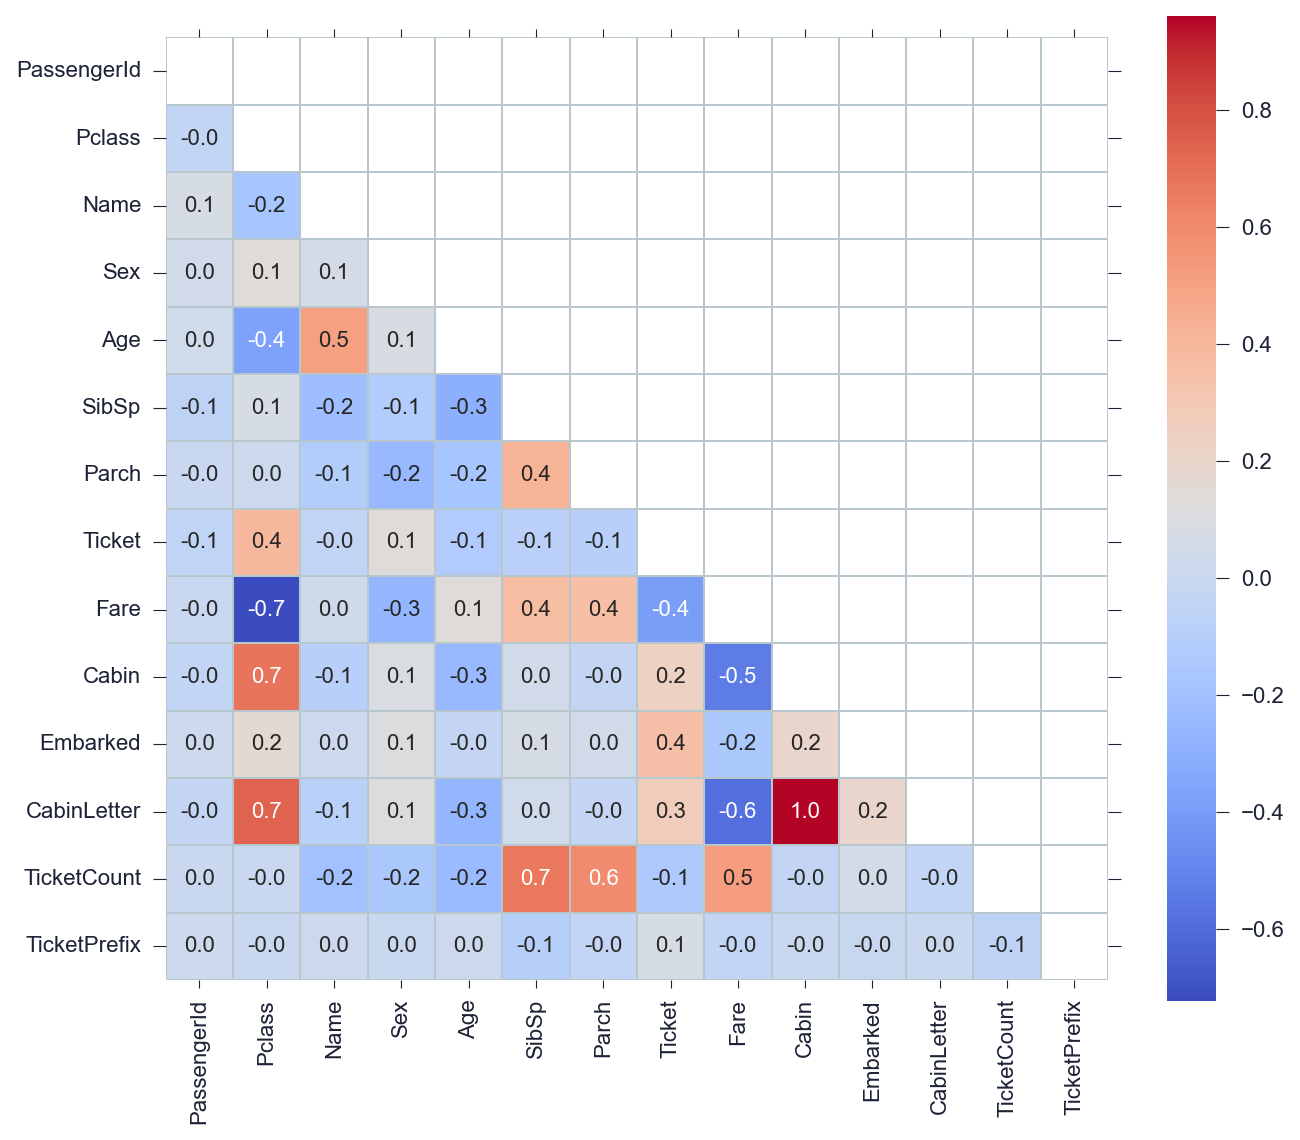

In [206]:
# Корреляционная матрица
cor = X_enc.corr(numeric_only=True)
matrix = np.triu(cor)

# Визуализация
ax = subplots(figsize=(9.5, 8))[1]
sns.heatmap(cor, annot=True, fmt='.1f', ax=ax, cmap='coolwarm', square=True,
            mask=matrix, linewidths=0.002, linecolor='#B8C6CE');

### 2.5. Зависимость Survived от количественных переменных
<a class="anchor" id="2.5"></a>

Построим диаграммы pairplot для переменных `Pclass`, `SibSp` и `Parch`:

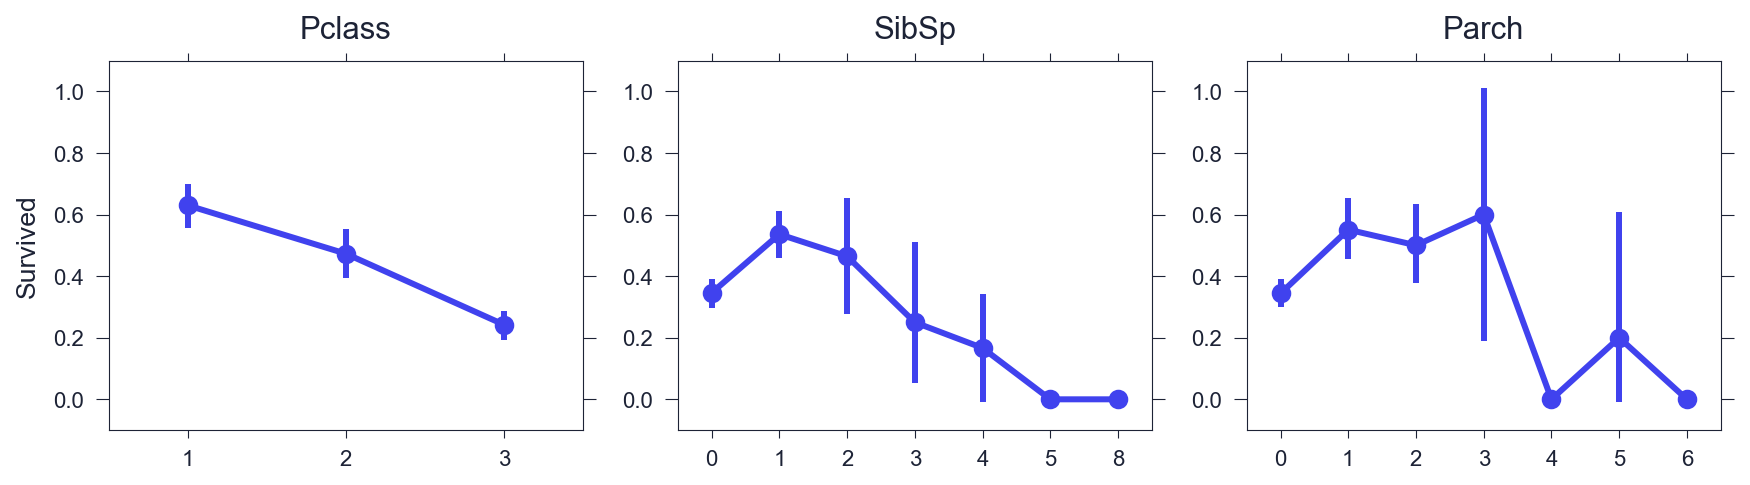

In [207]:
features = ['Pclass', 'SibSp', 'Parch']
fig, axes = subplots(figsize=(13, 3), ncols=3)
for i in range(3):
    sns.pointplot(x=features[i], y=y, data=X, ax=axes[i])
    axes[i].set_xlabel(None)
    axes[i].set_ylabel(None)
    axes[i].set_title(features[i])
    axes[i].set_ylim(-0.1, 1.1)
axes[0].set_ylabel('Survived');

Посмотрим, как меняется распределение переменных `Age` и `Fare` в зависимости от того, выжил ли пассажир:

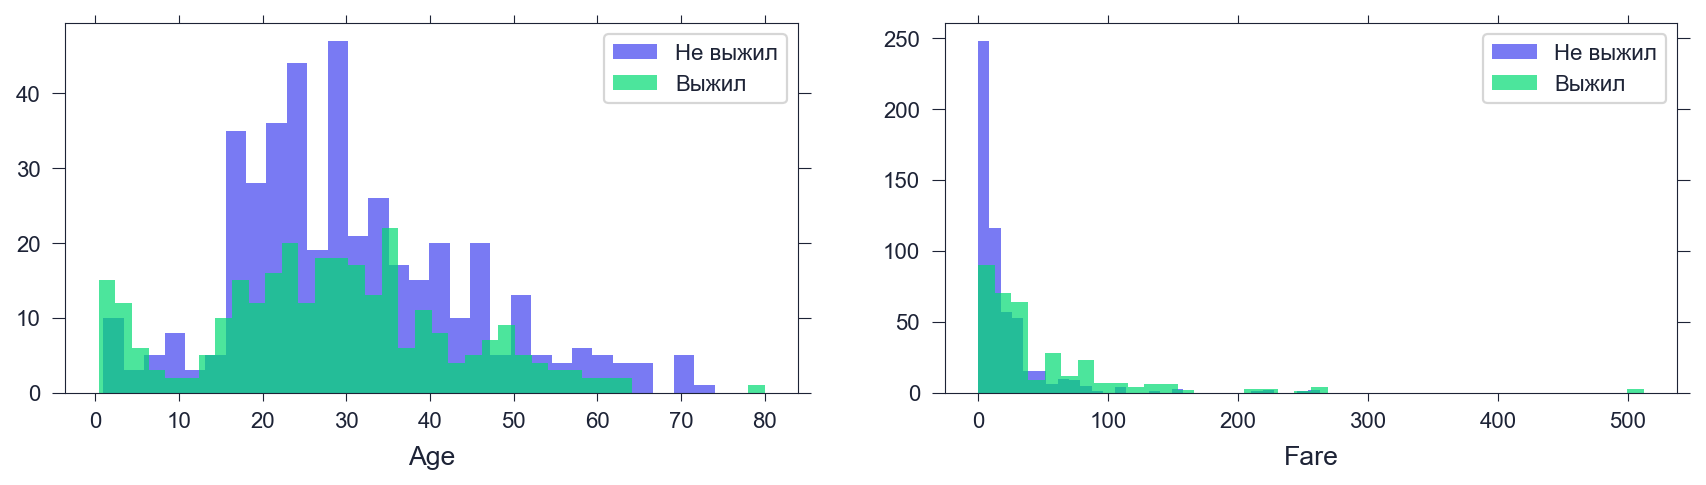

In [208]:
X_cop = X.join(y)
features = ['Age', 'Fare']

fig, axes = subplots(figsize=(13, 3), ncols=2)
for i in range(2):
    axes[i].hist(X_cop.loc[X_cop['Survived'] == 0, features[i]],
                 bins=30, label='Не выжил', alpha=0.7)
    axes[i].hist(X_cop.loc[X_cop['Survived'] == 1, features[i]],
                 bins=40, label='Выжил', alpha=0.7, color='#00DA72')
    axes[i].set_xlabel(features[i])
    axes[i].legend()

## 3. Предобработка данных
<a class="anchor" id="3.0"></a>

Объединим обучающую и тестовую выборки в единый датафрейм `df`:

In [209]:
df = pd.concat([X, test])
df.shape

(1309, 14)

### 3.1. Пропущенные значения
<a class="anchor" id="3.1"></a>

Заменим пропуски в столбце `Age` на медианные значения возраста для данного класса, пола и префикса пассажира:

In [210]:
# Замена
df['Age'] = (df.groupby(['Pclass', 'Sex', 'Name'])['Age']
               .transform(lambda x: x.fillna(x.median())))

# Проверим число пропусков
print(f'Число пропусков: {df.isna().sum().max()}')

Число пропусков: 0


### 3.2. Работа с признаками
<a class="anchor" id="3.2"></a>

#### 1) Pclass

Преобразуем значение `Pclass`, а также создадим столбец `PclassObj`, в котором значение класса — категориальная переменная:

In [211]:
# Создаем столбец PclassObj
df['PclassObj'] = df['Pclass'].astype('object')

# Преобразуем значения в столбце Pclass
mapping_pclass = {1: 1, 2: 0, 3: -1}
df['Pclass'] = df['Pclass'].map(mapping_pclass)

#### 2) Ticket

Добавим переменную `TicketPrefixGroup` — разделим `TicketPrefix` на 3 группы в зависимости от средней выживаемости пассажиров:

In [212]:
pivot = (X_cop.pivot_table(index='TicketPrefix',
                          values='Survived',
                          aggfunc=['mean', 'count']).reset_index()
              .sort_values(by=('mean', 'Survived')))
pivot.columns = ['TicketPrefix', 'MeanSurv', 'CountSurv']
pivot

,TicketPrefix,MeanSurv,CountSurv
14,SCA,0.000000,1
1,AS,0.000000,1
25,SP,0.000000,1
23,SOTONO,0.000000,2
4,CASOTON,0.000000,1
5,FC,0.000000,1
22,SOPP,0.000000,3
7,Fa,0.000000,1
21,SOP,0.000000,1
17,SCOW,0.000000,1


In [213]:
# Создадим функцию
def get_ticket_group(prefix):
    '''
    Функция принимает префикс и возвращает номер класса
    '''
    if prefix == 'NoPrefix':
        return 0
    elif prefix in ['CA', 'STONO', 'PC', 'PP', 'FCC']:
        return 1
    else:
        return -1

# Добавим столбец TicketPrefixGroup
df['TicketPrefixGroup'] = df['TicketPrefix'].apply(get_ticket_group)

Добавим переменную `NoPrefix`, принимающую значение 1, если в билете пассажира нет префикса:

In [214]:
df['NoPrefix'] = (df['TicketPrefix'] == 'NoPrefix').astype(int)

Заменим редкие значения в столбце `TicketPrefix` на `NoPrefix`:

In [215]:
drop = pivot.loc[pivot['CountSurv'] < 10, 'TicketPrefix'].tolist()
df['TicketPrefix'] = df['TicketPrefix'].replace(drop, 'NoPrefix')

Удалим столбец `Ticket`:

In [216]:
df = df.drop('Ticket', axis=1)

#### 3) Cabin

Добавим переменную `NoCabin`, принимающую значение 1, если номер каюты неизвестен:

In [217]:
df['NoCabin'] = (df['CabinLetter'] == 'N').astype(int)

Осуществим замену значений в столбце `Cabin` так, чтобы в каждой ячейке осталось по одному числу:

In [218]:
# Заменим некоторые значения
replaces = {'F E46': 'E46', 'F E57': 'E57', 'F E69': 'E69',
            'F G63': 'G63', 'F G73': 'G73', 'T': 'N', 'D': 'N', 'F': 'N'}
df['Cabin'] = df['Cabin'].replace(replaces)

In [219]:
# Оставим только числа
df['Cabin'] = df['Cabin'].str[:4]
df['Cabin'] = df['Cabin'].apply(lambda x: ''.join(filter(str.isdigit, x)))

Заменим пропуски на `N`, а числа - на `Right` или `Left` в зависимоти от того, четные они или нет

In [220]:
# Создаем функцию
def get_direction(cabin):
    '''
    Функция принимает номер каюты и возращает Right, если оно нечетное, и 
    Left, если оно четное
    '''
    if cabin == '':
        return 'N'
    elif int(cabin) % 2 == 0:
        return 'Left'
    else:
        return 'Right'

# Применяем ее к столбцу Cabin
df['Cabin'] = df['Cabin'].apply(get_direction)

#### 4) Family

Добавим переменную `FamilySize`:

In [221]:
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

Добавим переменные `FamilyType` и `IsAlone`:

In [222]:
# Создадим функцию
def get_type(size):
    '''
    Функцию принимает размер семьи и возвращает тип семьи
    '''
    if size == 1:
        return 1
    elif size > 4:
        return 2
    else:
        return 3

# Применим ее к столбцу FamilySize
df['FamilyType'] = df['FamilySize'].apply(get_type)

# Добавим переменную IsAlone
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

#### 5) Age

Добавим переменную `AgeGroup` с возрастной группой пассажира:

In [223]:
# Создадим функцию
def get_age_group(age):
    '''
    Функция принимает возраст пассажира и возвращает
    значение возрастной группы
    '''
    if age < 10:
        return 'A'
    elif age <= 24:
        return 'B'
    elif age <= 34:
        return 'C'
    elif age <= 42:
        return 'D'
    elif age <= 47:
        return 'E'
    elif age <= 60:
        return 'F'
    else:
        return 'G'

# Применим ее к столбцу Age
df['AgeGroup'] = df['Age'].apply(get_age_group)

Преобразуем распределение переменной `Age` в нормальное:

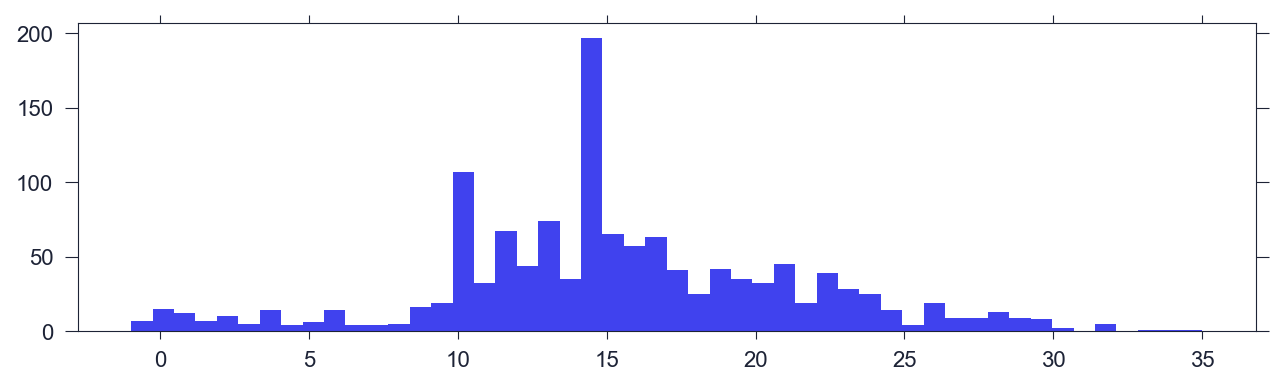

In [224]:
# Преобразуем
df['Age'], _ = stats.boxcox(df['Age']+0.0001)

# Смотрим распределение
df['Age'].hist(bins=50, figsize=(9.5, 2.5), grid=False);

#### 6) Fare

Аналогично преобразуем распределение признака `Fare` в нормальное:

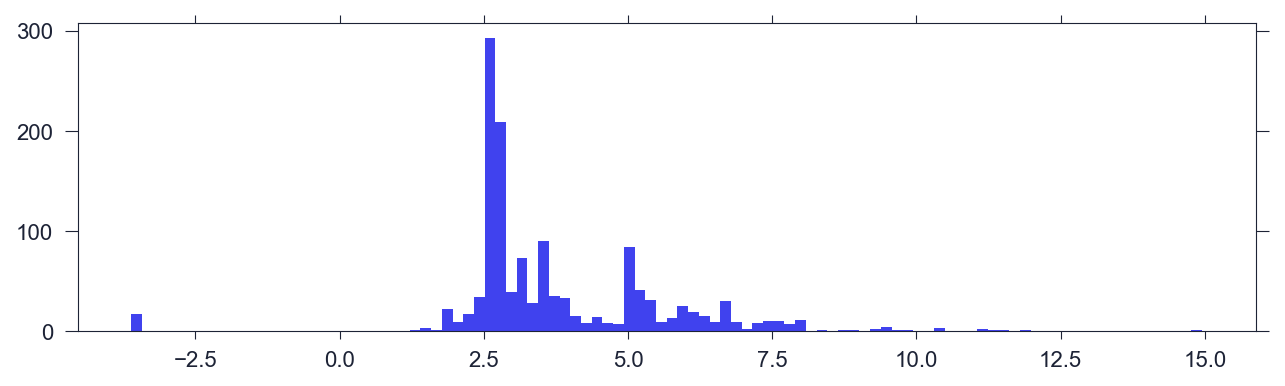

In [225]:
# Преобразуем
df['Fare'] = df['Fare'] / df['TicketCount']
df['Fare'], _ = stats.boxcox(df['Fare']+0.0001)

# Смотрим распределение
df['Fare'].hist(bins=100, figsize=(9.5, 2.5), grid=False);

Добавим переменную `FareGroup`:

In [226]:
# Создаем функцию
def get_fare_group(fare):
    '''
    Функция принимает значение Fare и возвращает группу
    '''
    if fare < 0:
        return 'A'
    elif fare < 3:
        return 'B'
    elif fare < 4.5:
        return 'C'
    elif fare < 6:
        return 'D'
    elif fare < 9:
        return 'E'
    else:
        return 'F'

# Применим ее к столбцу Fare
df['FareGroup'] = df['Fare'].apply(get_fare_group)

#### 7) Взаимодействия

Добавим столбцы с числовыми значениями `SexInt`, `AgeInt` и `FareInt`:

In [227]:
# Создадим функцию
def get_sex_int(sex):
    '''
    Принимает пол пассажира и возвращает 1 (мужской) или 2(женский)
    '''
    if sex == 'male':
        return 1
    else:
        return 2

# Применим ее к столбцу Sex
df['SexInt'] = df['Sex'].apply(get_sex_int)

# Добавим столбцы AgeInt и FareInt
df['AgeInt'] = (OrdinalEncoder()
                .fit_transform(np.array(df['AgeGroup']).reshape(-1, 1)))
df['FareInt'] = (OrdinalEncoder()
                .fit_transform(np.array(df['FareGroup']).reshape(-1, 1)))

Добавим переменные, отвечающие за взаимодействие признаков:

In [228]:
# Основные числовые признаки
important = ['SexInt', 'AgeInt', 'FareInt', 'Pclass']

# Остальные числовые признаки
other = [f for f in df.columns if df.dtypes[f] != 'object'
         and f != 'PassengerId' and f not in important]

In [229]:
# Взаимодейтвие основных признаков
df['Interaction'] = df['SexInt'] * df['AgeInt'] * df['FareInt'] * df['Pclass']
for i in range(3):
    n = 1
    while n <= 3 - i:
        df[f'{important[i]}x{important[i+n]}'] = (df[important[i]] * 
                                                  df[important[i+n]])
        n += 1

In [230]:
# Взаимодействие основных признаков с числовыми
for feature in important:
    for i in range(len(other)):
        df[f'{feature}x{other[i]}'] = df[feature] * df[other[i]]

In [231]:
df_catboost = df.copy()

### 3.3. Scaling и Encoding
<a class="anchor" id="3.3"></a>

In [172]:
# Scaling
scaling_cols = df.select_dtypes(np.number).columns.tolist()
scaling_cols.remove('PassengerId')
scaler = RobustScaler()
df[scaling_cols] = scaler.fit_transform(df[scaling_cols])

# Encoding
df = pd.get_dummies(df, dtype='int')

## 4. Обучение моделей
<a class="anchor" id="4.0"></a>

Разделим датафрейм `df` на обучающую и тестовую выборки:

In [173]:
X_train = df[df['PassengerId'] <= 891]
X_test = df[df['PassengerId'] > 891]

X_train = X_train.drop('PassengerId', axis=1)
X_test = X_test.drop('PassengerId', axis=1)

### 4.1. Попытка 1: Выбрать наилучшую модель
<a class="anchor" id="4.1"></a>

Создадим несколько моделей и оценим их точность с помощью кросс-валидации:

In [45]:
# Создадим функцию для оценки моделей
def get_accuracy(model):
    '''
    Функция принимает модель и рассчитывает метрику среднее значение
    Accuracy с применением кросс-валидации
    '''
    scores = cross_val_score(model, X_train, y, cv=5, scoring='accuracy')
    return scores.mean()

In [71]:
# Выберем модели
models = [LogisticRegression(max_iter=300), XGBClassifier(),
          RandomForestClassifier(),
          SVC(), GradientBoostingClassifier(), ExtraTreesClassifier(), 
          AdaBoostClassifier(), DecisionTreeClassifier(),
          KNeighborsClassifier()]
names = ['LogisticRegression', 'XGB', 'RandomForest', 'SVC',
         'GradientBoosting', 'ExtraTrees', 
         'AdaBoost', 'DecisionTree', 'KNeighbors']
metrics = []

# Определяем Accuracy
for model in models:
    metrics.append(get_accuracy(model))

,Names,CrossVal Accuracy
0,LogisticRegression,0.828291
4,GradientBoosting,0.821530
3,SVC,0.820426
2,RandomForest,0.817074
8,KNeighbors,0.809221
1,XGB,0.809196
6,AdaBoost,0.808085
5,ExtraTrees,0.805844
7,DecisionTree,0.764327


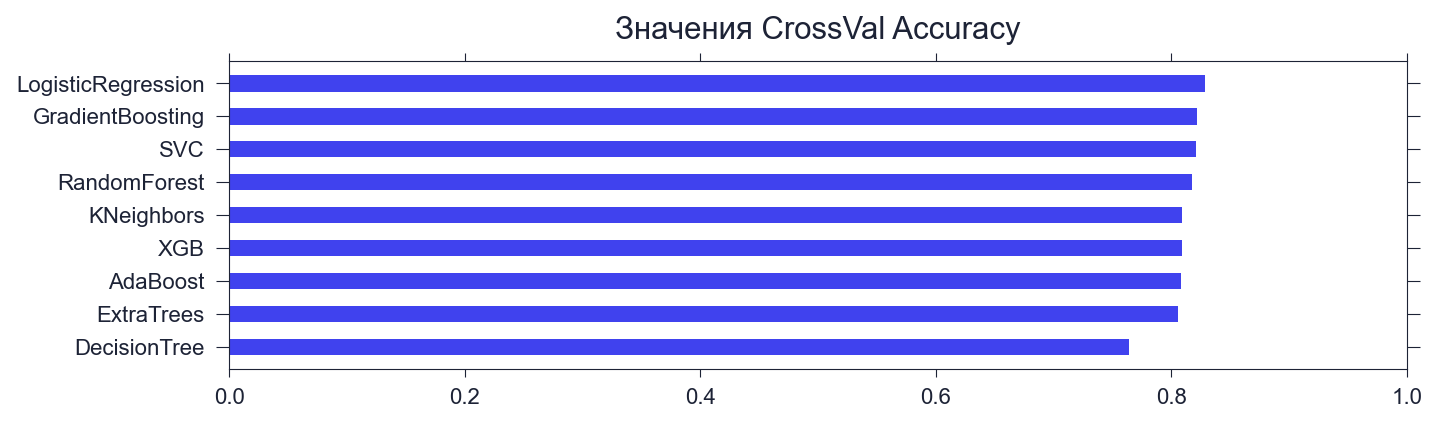

In [72]:
# Создаем датафрейм с результатми
performance = pd.DataFrame({'Names': names,
                            'CrossVal Accuracy': metrics})
performance = performance.sort_values(by='CrossVal Accuracy', ascending=True)
display(performance.sort_values(by='CrossVal Accuracy', ascending=False))

# Строим столбчатые диаграммы
ax = subplots(figsize=(9.5, 2.5))[1]
ax.barh(y=performance['Names'], width=performance['CrossVal Accuracy'],
        height=0.5)
ax.set_xlim(0, 1)
ax.set_title('Значения CrossVal Accuracy');

Настроим гиперпараметры модели `LogisticRegression`:

In [77]:
param_log = {
    'C': [1, 1.5, 2, 2.5, 3]
}
model_log = LogisticRegression(max_iter=10000)
rnd_srch_log = GridSearchCV(model_log, param_log, scoring='accuracy')
rnd_srch_log.fit(X_train, y)

print(f'Наилучшее значение Accuracy: {rnd_srch_log.best_score_}')
print(f'Наилучшие параметры:')
print(rnd_srch_log.best_params_)

Наилучшее значение Accuracy: 0.8339150084740442
Наилучшие параметры:
{'C': 2.5}


Создадим файл `log_submission` и посмотрим на результат участия в соревновании Kaggle:

In [78]:
model_log = rnd_srch_log.best_estimator_
preds_log = model_log.predict(X_test)

log_submission = submission.copy()
log_submission['Survived'] = preds_log
log_submission.to_csv('log_submission.csv', index=False)

Результат: 0.74401

### 4.2. Попытка 2: Pipeline
<a class="anchor" id="4.2"></a>

Используем `TPOT` для выбора оптимального `Pipeline`:

In [50]:
tpot = TPOTClassifier(generations=5, population_size=20, verbosity=2)
tpot.fit(X_train, y)
print(tpot.fitted_pipeline_)

                                                                                
Generation 1 - Current best internal CV score: 0.8305379448873266
                                                                                
Generation 2 - Current best internal CV score: 0.8327788588286987
                                                                                
Generation 3 - Current best internal CV score: 0.8361182599962339
                                                                                
Generation 4 - Current best internal CV score: 0.8361182599962339
                                                                                
Generation 5 - Current best internal CV score: 0.836137091205825
                                                                                
Best pipeline: ExtraTreesClassifier(ZeroCount(input_matrix), bootstrap=True, criterion=gini, max_features=1.0, min_samples_leaf=3, min_samples_split=2, n_estimators=100)
Pipeline(steps=

Применим предлагаемый `Pipeline`:

In [51]:
# Pipeline
pipeline = tpot.fitted_pipeline_
pipeline.fit(X_train, y)

# Предсказания
preds_tpot = pipeline.predict(X_test)

# Submission
tpot_submission = submission.copy()
tpot_submission['Survived'] = preds_tpot
tpot_submission.to_csv('tpot_submission.csv', index=False)

Результат: 0.77272. Посмотрим, получится ли улучшить его с использованием `VotingClassifier`.

### 4.3. Попытка 3: Voting Classifier
<a class="anchor" id="4.3"></a>

Добавим еще несколько моделей из наилучших, настроим их гиперпараметры и применим `VotingClassifier`:

In [48]:
param_svc = {
    'kernel': ['rbf'],
    'C': [0.001, 0.01, 0.1, 1, 10, 50, 100, 200, 300, 1000, 3000],
    'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1, 1 ]
}
model_svc = SVC()
rnd_srch_svc = GridSearchCV(model_svc, param_svc, scoring='accuracy')
rnd_srch_svc.fit(X_train, y)

print(f'Наилучшее значение Accuracy: {rnd_srch_svc.best_score_}')
print(f'Наилучшие параметры:')
print(rnd_srch_svc.best_params_)

Наилучшее значение Accuracy: 0.8316301550436256
Наилучшие параметры:
{'C': 3000, 'gamma': 0.0001, 'kernel': 'rbf'}


In [60]:
# Gradient Boosting - gbc
param_gbc = {
    'n_estimators' : [1, 2, 4,  32, 100, 150, 200,  300],
    'learning_rate': [1, 0.25, 0.1, 0.05, 0.01],
    'max_depth': np.arange(1, 35, 8),
    'min_samples_leaf': np.linspace(0.1, 0.5, 4, endpoint=True)
}
model_gbc = GradientBoostingClassifier()
rnd_srch_gbc = GridSearchCV(model_gbc, param_gbc, scoring='accuracy')
rnd_srch_gbc.fit(X_train, y)

print(f'Наилучшее значение Accuracy: {rnd_srch_gbc.best_score_}')
print(f'Наилучшие параметры:')
print(rnd_srch_gbc.best_params_)

Наилучшее значение Accuracy: 0.8383968363567886
Наилучшие параметры:
{'learning_rate': 0.25, 'max_depth': 9, 'min_samples_leaf': 0.23333333333333334, 'n_estimators': 150}


In [61]:
# KNeighbors - knn
param_knn = {
    'n_neighbors': [1, 3, 5, 7]
}
model_knn = KNeighborsClassifier()
rnd_srch_knn = GridSearchCV(model_knn, param_knn, scoring='accuracy')
rnd_srch_knn.fit(X_train, y)

print(f'Наилучшее значение Accuracy: {rnd_srch_knn.best_score_}')
print(f'Наилучшие параметры:')
print(rnd_srch_knn.best_params_)

Наилучшее значение Accuracy: 0.8092210156299039
Наилучшие параметры:
{'n_neighbors': 5}


In [62]:
# XGBoost - xgb
param_xgb = {
    'min_child_weight': np.linspace(1, 10, 5, endpoint=True),
    'gamma': np.linspace(0.5, 5, 5, endpoint=True),
    'subsample': np.linspace(0.5, 1, 5, endpoint=True),
    'colsample_bytree': np.linspace(0.5, 1, 5, endpoint=True),
    'max_depth': [1, 2, 4, 8, 10]
}
model_xgb = XGBClassifier()
rnd_srch_xgb = GridSearchCV(model_xgb, param_xgb, scoring='accuracy')
rnd_srch_xgb.fit(X_train, y)

print(f'Наилучшее значение Accuracy: {rnd_srch_xgb.best_score_}')
print(f'Наилучшие параметры:')
print(rnd_srch_xgb.best_params_)

Наилучшее значение Accuracy: 0.8451133011110412
Наилучшие параметры:
{'colsample_bytree': 0.625, 'gamma': 1.625, 'max_depth': 2, 'min_child_weight': 1.0, 'subsample': 0.75}


In [63]:
# Random Forest - forest
param_forest = {
    'max_depth' : [4, 6, 8],
    'n_estimators': [50, 10],
    'min_samples_split': [2, 3, 10],
    'min_samples_leaf': [1, 3, 10],
    'bootstrap': [False]
}
model_forest = RandomForestClassifier()
rnd_srch_forest = GridSearchCV(model_forest, param_forest, scoring='accuracy')
rnd_srch_forest.fit(X_train, y)

print(f'Наилучшее значение Accuracy: {rnd_srch_forest.best_score_}')
print(f'Наилучшие параметры:')
print(rnd_srch_forest.best_params_)

Наилучшее значение Accuracy: 0.8350260498399347
Наилучшие параметры:
{'bootstrap': False, 'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 3, 'n_estimators': 10}


Посмотрим на корреляцию результатов для моделей:

In [80]:
# XGBoost - 0.8451133011110412
model_xgb = rnd_srch_xgb.best_estimator_
model_xgb.fit(X_train, y)
preds_xgb = model_xgb.predict(X_test)

# Gradient Boosting - 0.8383968363567886
model_gbc = rnd_srch_gbc.best_estimator_
model_gbc.fit(X_train, y)
preds_gbc = model_gbc.predict(X_test)

# TPOT - 0.836137091205825, preds_tpot

# Random Forest - 0.8350260498399347
model_forest = rnd_srch_forest.best_estimator_
model_forest.fit(X_train, y)
preds_forest = model_forest.predict(X_test)

# Logistic Regression - 0.8339150084740442
model_log = rnd_srch_log.best_estimator_
model_log.fit(X_train, y)
preds_log = model_log.predict(X_test)

# SVC - 0.8316301550436256
model_svc = rnd_srch_svc.best_estimator_
model_svc.fit(X_train, y)
preds_svc = model_svc.predict(X_test)

# KNeighbors - 0.8092210156299039
model_knn = rnd_srch_knn.best_estimator_
model_knn.fit(X_train, y)
preds_knn = model_knn.predict(X_test)

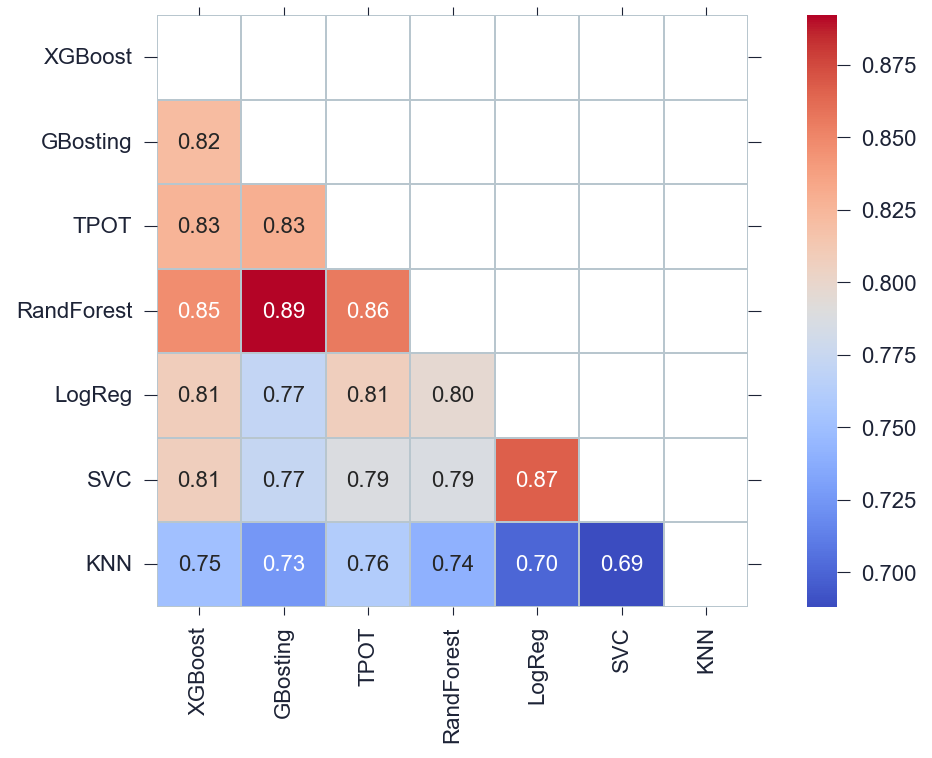

In [88]:
# Создадим датафрейм
xgb = pd.Series(preds_xgb, name='XGBoost')
gbc = pd.Series(preds_gbc, name='GBosting')
tpot = pd.Series(preds_tpot, name='TPOT')
forest = pd.Series(preds_forest, name='RandForest')
log = pd.Series(preds_log, name='LogReg')
svc = pd.Series(preds_svc, name='SVC')
knn = pd.Series(preds_knn, name='KNN')

result = pd.concat([xgb, gbc, tpot, forest, log, svc, knn], axis=1)
cor = result.corr()
matrix = np.triu(cor)

ax = subplots(figsize=(9.5, 4.8))[1]
sns.heatmap(cor, annot=True, fmt='.2f', ax=ax,
            cmap='coolwarm', square=True, mask=matrix, linewidths=0.002,
            linecolor='#B8C6CE');

Попробуем использовать 3, 5 и 7 наилучших моделей:

In [94]:
# 3 модели
voting_3 = VotingClassifier(estimators=[
    ('TPOT', pipeline), ('XGB', model_xgb), ('GBC', model_gbc)
], voting='soft', n_jobs=4)

voting_3.fit(X_train, y)
preds_3 = voting_3.predict(X_test)

submission_3 = submission.copy()
submission_3['Survived'] = preds_3
submission_3.to_csv('submission_3.csv', index=False)

Результат: 0.76555.

In [95]:
# 5 моделей
voting_5 = VotingClassifier(estimators=[
    ('TPOT', pipeline), ('XGB', model_xgb), ('GBC', model_gbc),
    ('Forest', model_forest), ('Log', model_log)
], voting='soft', n_jobs=4)

voting_5.fit(X_train, y)
preds_5 = voting_5.predict(X_test)

submission_5 = submission.copy()
submission_5['Survived'] = preds_5
submission_5.to_csv('submission_5.csv', index=False)

Результат: 0.76794.

In [97]:
# 7 моделей
voting_7 = VotingClassifier(estimators=[
    ('XGB', model_xgb), ('Log', model_log), ('SVC', model_svc), 
    ('GBC', model_gbc), ('TPOT', pipeline),
    ('Forest', model_forest), ('KNN', model_knn)
], voting='soft', n_jobs=4)

voting_7.fit(X_train, y)
preds_7 = voting_5.predict(X_test)

submission_7 = submission.copy()
submission_7['Survived'] = preds_7
submission_7.to_csv('submission_7.csv', index=False)

Результат: 0.76794.

### 4.4. Попытка 4: CatBoostClassifier
<a class="anchor" id="4.4"></a>

Заменим типы данных:

In [270]:
types = [f for f in df_catboost.columns if df_catboost.dtypes[f] == 'float']
types.remove('Age')
types.remove('Fare')

In [271]:
for type in types:
    df_catboost[type] = df_catboost[type].astype(int)

Получим данные:

In [272]:
X_train = df_catboost[df_catboost['PassengerId'] <= 891]
X_test = df_catboost[df_catboost['PassengerId'] > 891]

X_train = X_train.drop('PassengerId', axis=1)
X_test = X_test.drop('PassengerId', axis=1)

Выберем категориальные переменные:

In [273]:
cat_features = [f for f in X_train.columns if X_train.dtypes[f] != 'float']

Разделим выборки:

In [274]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y, 
                                                      train_size=0.85)

Создаем и обучаем модель:

In [275]:
model_cat = CatBoostClassifier(eval_metric='Accuracy', use_best_model=True)
model_cat.fit(X_train, y_train, cat_features=cat_features,
              eval_set=(X_valid, y_valid))

Learning rate set to 0.029583
0:	learn: 0.8282695	test: 0.8208955	best: 0.8208955 (0)	total: 22.5ms	remaining: 22.5s
1:	learn: 0.8256275	test: 0.7985075	best: 0.8208955 (0)	total: 48.6ms	remaining: 24.3s
2:	learn: 0.8348745	test: 0.8432836	best: 0.8432836 (2)	total: 72.4ms	remaining: 24s
3:	learn: 0.8322325	test: 0.8432836	best: 0.8432836 (2)	total: 91.9ms	remaining: 22.9s
4:	learn: 0.8428005	test: 0.8432836	best: 0.8432836 (2)	total: 115ms	remaining: 22.8s
5:	learn: 0.8467635	test: 0.8358209	best: 0.8432836 (2)	total: 136ms	remaining: 22.5s
6:	learn: 0.8441215	test: 0.8358209	best: 0.8432836 (2)	total: 162ms	remaining: 22.9s
7:	learn: 0.8428005	test: 0.8432836	best: 0.8432836 (2)	total: 184ms	remaining: 22.8s
8:	learn: 0.8428005	test: 0.8432836	best: 0.8432836 (2)	total: 209ms	remaining: 23s
9:	learn: 0.8348745	test: 0.8432836	best: 0.8432836 (2)	total: 235ms	remaining: 23.3s
10:	learn: 0.8348745	test: 0.8432836	best: 0.8432836 (2)	total: 259ms	remaining: 23.3s
11:	learn: 0.8348745	te

In [277]:
preds_cat = model_cat.predict(X_test)

submission_cat = submission.copy()
submission_cat['Survived'] = preds_cat
submission_cat.to_csv('submission_cat.csv', index=False)

Результат: 0.75837. Таким образом, лучший результат — 0.77272.

<img src="ext.png" alt="ext"/>